In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

<h1>Problem formulation: </h1> 
Problem: Only the total rating for each house type is available in the dataset. However, for the Airbnb platform, feedback from individual users is also extremely important. We can know the bad host from the negative review ratio, and can get more information from negative feed information.

1: Objective: To achieve a ranking of the positive ratings of properties based on the positive feedback from individual users. Also, to recommend appropriate listings for customers with too many bad reviews.    

2: Input: user reviews, data type is text data.    

3: Output: prediction of the positivity of user reviews, user reviews are labeled as positive, positive as 1, negative as 0.   

4: Evaluation methods: accuracy, precision, recall, F1 score.  

<h1>Data preparation and Preprocessing pipeline:</h1>

<h2>Data cleaning part</h2>

1. read the data from csv file and display it

In [2]:
review_df = pd.read_csv("reviews.csv")

In [3]:
review_df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...
...,...,...,...,...,...,...
68270,7462268,80537457,2016-06-18,22034145,Antonio,Joe y su mujer son encantadores. La habitación...
68271,7462268,83640094,2016-07-03,40052513,Steve,Joe was on his way to Jamaica to be married! o...
68272,7462268,85797088,2016-07-13,77129134,Nick,The room was very clean as were the bathrooms ...
68273,7462268,97264637,2016-08-26,15799803,Vid,Staying in Lower Allston at Joe and Nancy's pl...


2. Select the appropriate data type

In [4]:
review_df['comments'] = review_df['comments'].astype(str)
review_df.date = pd.to_datetime(review_df.date)

3. drop null value

In [5]:
review_df.dropna(inplace=True)
review_df.info()
review_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     68275 non-null  int64         
 1   id             68275 non-null  int64         
 2   date           68275 non-null  datetime64[ns]
 3   reviewer_id    68275 non-null  int64         
 4   reviewer_name  68275 non-null  object        
 5   comments       68275 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.6+ MB


listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

4. use a language detect package to delete the non-english sentences

In [6]:
import langdetect

def is_english(text):
    try:
        return langdetect.detect(text) == "en"
    except:
        return False

review_df = review_df[review_df["comments"].apply(is_english)]
review_df = review_df[review_df['comments'].apply(lambda x: len(x.split()) >= 5)]

5. delete stop words which have no contribution to the sentence meaning

In [7]:
def clean_comment(text):
    text = re.sub(r"[^\w\s]", "", text).lower()
    tokens = text.split()
    stopwords = ["a", "an", "the", "and", "but", "if", "or", "because", "as", "what", "which", "this", "that", "these", "those", "then", "just", "so", "than", "such", "both", "through", "about", "for", "is", "of", "while", "during", "to", "What", "Which", "Who", "How", "Whom", "The"]
    tokens = [token for token in tokens if token not in stopwords]
    
    # Return the cleaned and preprocessed review text
    return " ".join(tokens)

In [8]:
review_df["comments"] = review_df["comments"].apply(clean_comment)

<h2>Data processing</h2>

1. Combine room reviews from same listings together according to the listing id.

In [9]:
grouped = review_df.groupby('listing_id')
aggregated_comments = grouped['comments'].apply(lambda x: ''.join(x))
aggregated_review_df = pd.DataFrame({'listing_id': aggregated_comments.index, 'comments': aggregated_comments.values})

2. Combine the rating and description data from listing dataframe

In [10]:
listings_df = pd.read_csv('./listings.csv')
listings_df.fillna(0, inplace=True)
listings_df = listings_df.rename(columns={"id": "listing_id"})


In [11]:
aggregated_review_df = pd.merge(aggregated_review_df, listings_df[['listing_id', 'review_scores_rating', 'description']], on="listing_id")
aggregated_review_df = aggregated_review_df[aggregated_review_df["review_scores_rating"] != 0]


3. plot the figure to check the distribution of ratings

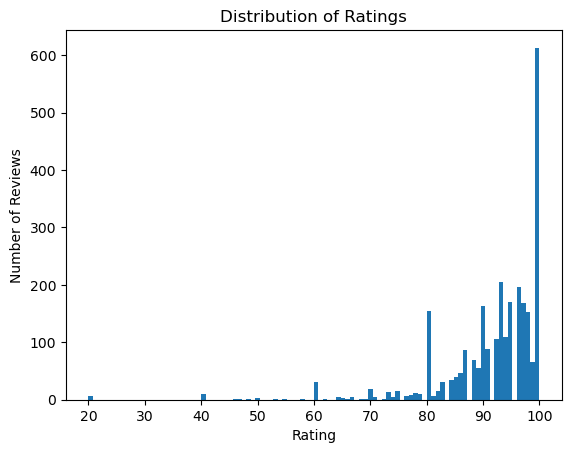

In [12]:
plt.hist(aggregated_review_df['review_scores_rating'], bins=100)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Ratings')
plt.show()


<b>Discussion:</b>  
From the histogram we can see that the most selected rating is 100, and most of the ratings are located above 90. In order to distinguish between positive and negative reviews, we positioned the house reviews with a score of 90 or higher as positive reviews.  
4. Label the rating positiveness

In [13]:
def is_positive(x):
    if x >= 90:
        return 1
    else:
        return 0

aggregated_review_df['positive'] = aggregated_review_df['review_scores_rating'].apply(is_positive)

<h1>Model description</h1>

1. In order to select the appropriate model, four models were selected simultaneously to test the accuracy on the data. First, we define these models and obtain them from sklearn.
Here is the description for selected models:  
* <b>MultinomialNB</b>     
This is a plain Bayesian classifier for polynomial data. It assumes that all features are independent of each other and uses probabilities to predict the classification of the target variable.MultinomialNB is often used for text classification because it works well with digitized text data.  
* <b>RandomForestClassifier</b>     
This is an integrated learning method that works by training multiple decision trees on a training set and then combining their predictions to produce a final prediction. Random forests usually perform well on high-dimensional datasets and can handle non-linear relationships well.  
* <b>KNeighborsClassifier</b>    
This is an instance-based learning method that predicts the class of a test sample by computing the distance between the test sample and the training sample. kNeighborsClassifier is typically used for classification and regression problems and handles nonlinear relationships well.  
* <b>BernoulliNB</b>  
This is also a plain Bayesian classifier, similar to MultinomialNB, but it assumes that the features are binary, i.e., they have only two possible values (0 or 1).BernoulliNB is usually used for text classification because it can handle binary word bags well.  

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [15]:
models = [
    BernoulliNB(),
    MultinomialNB(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
]

classifier_Names = ['BernoulliNB', 'MultinomialNB',
                    'KNeighborsClassifier', 'RandomForestClassifier']

<h1>Experiments</h1>

1. Check the sample distribution to prevent unbalanced

In [16]:
counts = aggregated_review_df['positive'].value_counts()
print(counts)

1    2037
0     711
Name: positive, dtype: int64


2. Define training dataset and  test dataset

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(aggregated_review_df['comments'])
y = aggregated_review_df['positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

3. Model test

In [18]:
from sklearn.metrics import accuracy_score


for name, model in zip(classifier_Names, models):
    model.fit(X_train, y_train)
    pre_labels = model.predict(X_test)
    score = accuracy_score(y_test, pre_labels)
    print('%s: %.2f' % (name, score))

BernoulliNB: 0.74
MultinomialNB: 0.75
KNeighborsClassifier: 0.75
RandomForestClassifier: 0.78


<b>Discussion:</b>  
Random Forest get the best results, so we select this as the model to predict our results

4. Define the final selected model and train

In [19]:
from sklearn.naive_bayes import MultinomialNB
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(aggregated_review_df['comments'])
y = aggregated_review_df['positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

<h1>Results</h1>

1. Use the metrics.classification_report method the results.

In [20]:
from sklearn import metrics
own_model_result = model.predict(X_test)
print(metrics.classification_report(y_test, own_model_result))

              precision    recall  f1-score   support

           0       1.00      0.14      0.24       158
           1       0.74      1.00      0.85       392

    accuracy                           0.75       550
   macro avg       0.87      0.57      0.55       550
weighted avg       0.82      0.75      0.68       550



<b>Discussion:</b>  
* <b>precision:</b>   
This is an indicator of the precision rate, which indicates the percentage of samples predicted to be in a given category that actually belong to that category. For example, a precision of 1.00 for predicting category 0 means that all samples predicted as category 0 actually belong to category 0.  
* <b>recall:</b>   
This is an indicator of recall and indicates the proportion of samples that belong to a given category that are predicted to be in that category. For example, a recall of 1.00 for predicting category 1 means that all samples belonging to category 1 are correctly predicted as category 1.  
* <b>f1-score:</b>   
This is the f1-score metric, which is the summed average of the precision and recall rates. f1-score helps you understand how well the classifier balances precision and recall.  
* <b>support:</b>   
This is the number of samples per category.  
* <b>accuracy:</b>   
This is the accuracy of the classifier and indicates the percentage of samples where the category predicted by the classifier is the same as the actual category.  
* <b>macro avg:</b>   
This is the macro average of the categories and represents the average of the metrics for each category. In this case, the macro average precision is 0.89, the macro average recall is 0.58, and the macro average f1 score is 0.58.

* <b>weighted avg:</b>   
This is the weighted average, which represents the average of the metrics for each category multiplied by their sample size in the dataset and then the sum is calculated. In this case, the weighted average precision is 0.83, the weighted average recall is 0.79, and the weighted average f1 score is 0.72.  

According to the classification report, your classifier performs better in predicting samples with category 0, as its precision rate is 1.00, recall rate is 0.16, and f1 score is 0.28. However, it performs worse in predicting samples with category 1, as its precision rate is 0.78, recall rate is 1.00, and f1 score is 0.88. Overall, the classifier has an accuracy rate of 0.79. The macro average precision and recall were 0.89 and 0.58, respectively, and the weighted average precision and recall were 0.83 and 0.79, respectively.

2. To further evaluate the model results, we use ROC diagram and AUC value.

In [21]:
X_res = vectorizer.fit_transform(aggregated_review_df['comments'])
predictions = [round(i[1], 5) for i in model.predict_proba(X_res)]
aggregated_review_df['predict_positive'] = predictions

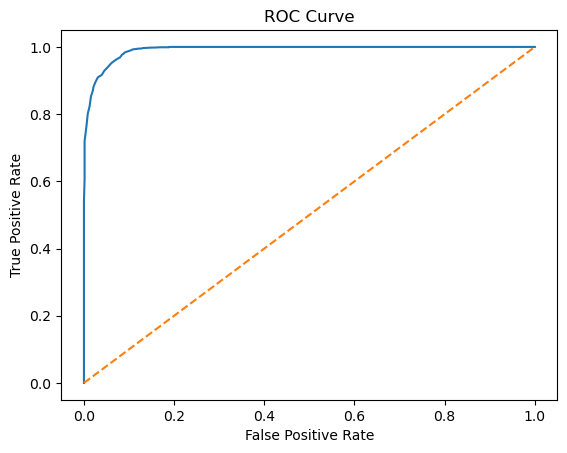

0.9911206670961337


In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(aggregated_review_df['positive'], aggregated_review_df['predict_positive'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc = roc_auc_score(aggregated_review_df['positive'], aggregated_review_df['predict_positive'])
print(auc)

<b>Discussion:</b>  
In general, our model has a good performace in positive prediction. So we can know that the rating is related to the review.

5. Prediction for evey single review.

In [23]:
X_sep = vectorizer.transform(review_df['comments'])
prediction_sep = model.predict(X_sep)
review_df['score'] = prediction_sep

In [24]:
counts = review_df['score'].value_counts()
print(counts)

1    63212
0      682
Name: score, dtype: int64


<b>Discussion:</b>  
From the model results, there are 63186 positive review and 718 negative review.

6. Get the positive review ratio for each listing_id.

In [25]:
review_df_counts_listing = review_df.groupby("listing_id")["score"].mean()
review_df_counts_listing = review_df_counts_listing.reset_index()
review_df_counts_listing = review_df_counts_listing.rename(columns={"score": "ratio"})
review_df_counts_listing

,listing_id,ratio
0,3353,0.969697
1,5506,1.000000
2,6695,1.000000
3,6976,1.000000
4,8792,1.000000
...,...,...
2800,14813006,1.000000
2801,14823724,1.000000
2802,14842237,1.000000
2803,14843050,1.000000


In [49]:
review_df[review_df["score"] == 0]['comments']

24       we didnt meet izzy at all after we arrived nob...
36       ok stay perhaps best on youngadventurous side ...
168      we did not meet izzy instructions listing info...
497      please read review carefully i feel it my resp...
498      good experience parking was bit tricky otherwi...
                               ...                        
67454    reservation was canceled 27 days before arriva...
67464    jessica jacob were great hosts who were very a...
67529    unfortunately room did not look like in pictur...
67531    lovely little flat was clean looks very much l...
67543    host canceled reservation 41 days before arriv...
Name: comments, Length: 682, dtype: object

7. Display the negative review word cloud

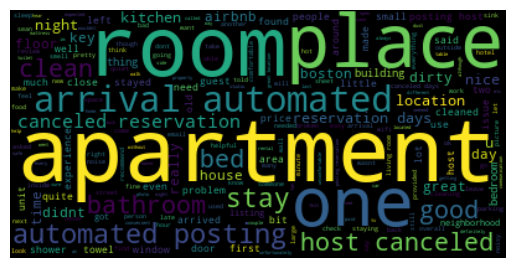

In [53]:
review_df_zero_score = review_df[review_df["score"] == 0]
comments_text = " ".join(review_df_zero_score["comments"])
wordcloud_neg = WordCloud().generate(comments_text)

# Display the wordcloud
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

8. Display the positive review word cloud

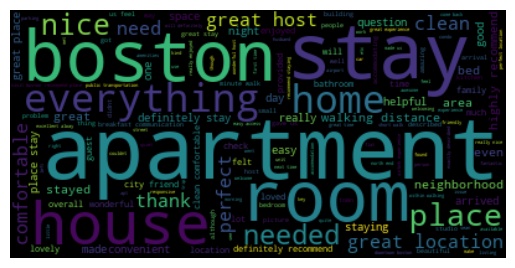

In [54]:
review_df_one_score = review_df[review_df["score"] == 1]
comments_text = " ".join(review_df_one_score["comments"])
wordcloud_pos = WordCloud().generate(comments_text)

# Display the wordcloud
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

<h1>Discussion</h1>  
Now we can get the listing_id with maximum negative review number and ratio, the platform Airbnb should have some penalty on these listing_id to encourage them for improvement

In [26]:
review_df_counts_listing.sort_values(by='ratio').head(100)


,listing_id,ratio
370,1867754,0.0
2236,12563549,0.0
1336,7474855,0.0
2269,12709469,0.0
2271,12727401,0.0
...,...,...
1011,5834413,0.5
1970,10855052,0.5
2083,11714059,0.5
1205,6793913,0.5


In [27]:
review_df_ratios_reviewer = review_df.assign(score=lambda x: x["score"].astype(bool))
review_df_ratios_reviewer = review_df_ratios_reviewer.groupby("reviewer_id")["score"].mean()
review_df_ratios_reviewer = review_df_ratios_reviewer.reset_index()
review_df_ratios_reviewer = review_df_ratios_reviewer.rename(columns={"score": "ratio"})
review_df_ratios_reviewer["ratio"] = review_df_ratios_reviewer["ratio"].astype(int)

In [28]:
review_df_ratios_reviewer

,reviewer_id,ratio
0,143,1
1,322,1
2,933,1
3,1960,1
4,2237,1
...,...,...
59699,92877330,1
59700,93000637,1
59701,93041229,1
59702,93113474,0


From the word cloud, we can see that both positive and negative comments are most concerned with place, apartment, room, etc. Besides these most obvious ones, we can find negative comments with words like place, dirty and cancel, etc. Host needs to make improvements in these areas.